# Imports 

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [109]:
weather_data = pd.read_csv('../data/GlobalWeatherRepository.csv')
weather_data.sample(5)

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
42229,Luxembourg,Luxembourg,49.6117,6.13,Europe/Luxembourg,1734691500,2024-12-20 11:45,2.9,37.2,Overcast,...,10.730,15.355,1,1,08:29 AM,04:37 PM,10:22 PM,12:00 PM,Waning Gibbous,77
42524,Antigua and Barbuda,Saint John's,17.1167,-61.85,America/Antigua,1734861600,2024-12-22 06:00,27.0,80.6,Patchy rain nearby,...,15.014,24.601,1,2,06:33 AM,05:40 PM,No moonrise,11:56 AM,Last Quarter,57
55358,Bahamas,Nassau,25.0833,-77.35,America/Nassau,1740564000,2025-02-26 05:00,16.2,61.2,Clear,...,8.695,12.950,1,1,06:34 AM,06:10 PM,05:43 AM,04:56 PM,Waning Crescent,5
9484,Timor-Leste,Dili,-8.5600,125.57,Asia/Dili,1719926100,2024-07-02 22:15,24.5,76.1,Clear,...,1.500,6.100,1,1,06:53 AM,06:31 PM,03:06 AM,03:04 PM,Waning Crescent,18
20298,Saint Kitts and Nevis,Basseterre,17.3000,-62.72,America/St_Kitts,1724932800,2024-08-29 08:00,28.1,82.6,Partly cloudy,...,2.500,6.400,1,1,05:57 AM,06:26 PM,01:53 AM,03:37 PM,Waning Crescent,24


# Check for null values

### Update: no null values

In [66]:
print(weather_data.isnull().sum())

country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

# Removing outliers (outlier is either Q1 - 1.5IQR or Q3 + 1.5IQR)

### Dropping un-needed columns

In [110]:
cols_to_drop = ['sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']  
weather_data = weather_data.drop(columns=cols_to_drop, errors='ignore')

### Keeping track of outlier values (but not doing anything with them until we see what's going on)

In [111]:
def flag_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return df

In [112]:
continuous_cols= [
    'temperature_celsius', 'wind_mph', 'pressure_mb', 'precip_mm',
    'humidity', 'cloud', 'feels_like_celsius', 'visibility_km',
    'uv_index', 'gust_mph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10'
]
weather_data = flag_outliers_iqr(weather_data, continuous_cols)

# EDA w/ matplotlib and seaborn

### Correlation heatmap

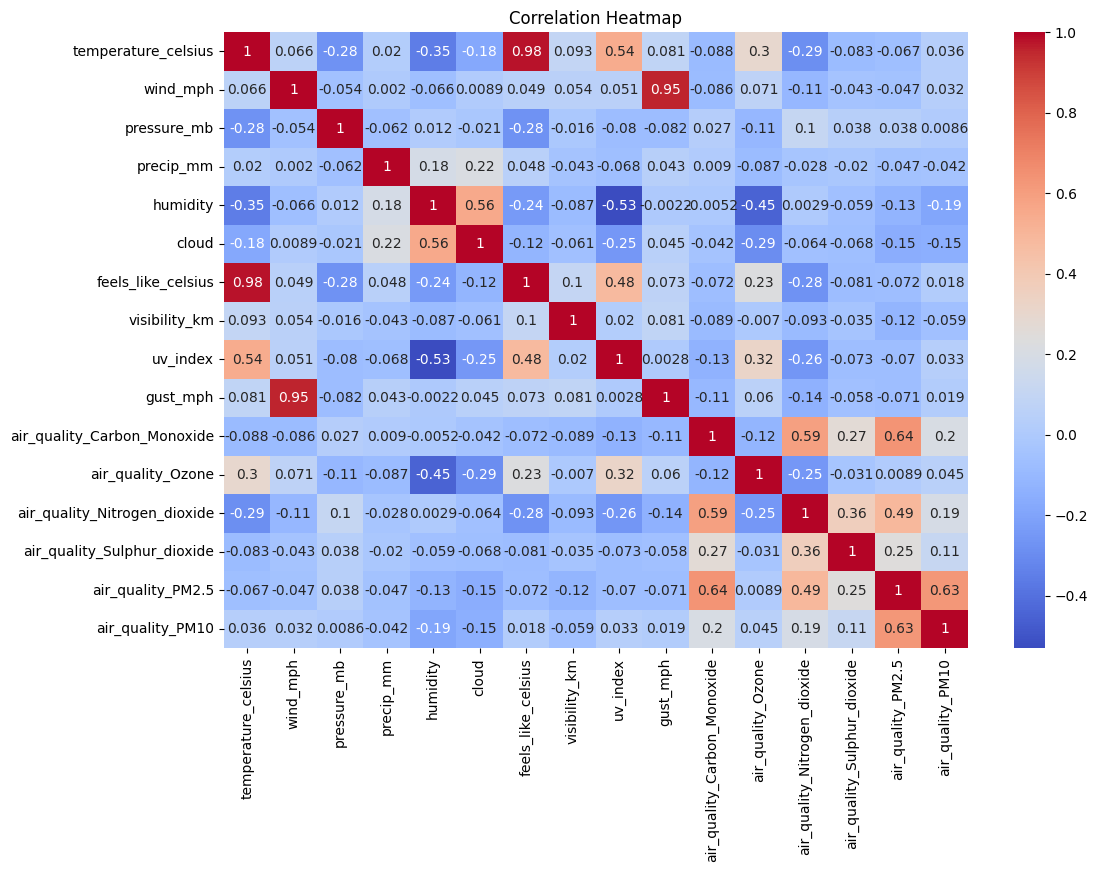

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(weather_data[continuous_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### Gloabl warming?? (Temp & Precipitation over time)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='last_updated', y='temperature_celsius', data=weather_data)
plt.title('Temperature Trend Over Time')
plt.xticks(rotation=45)
plt.show()

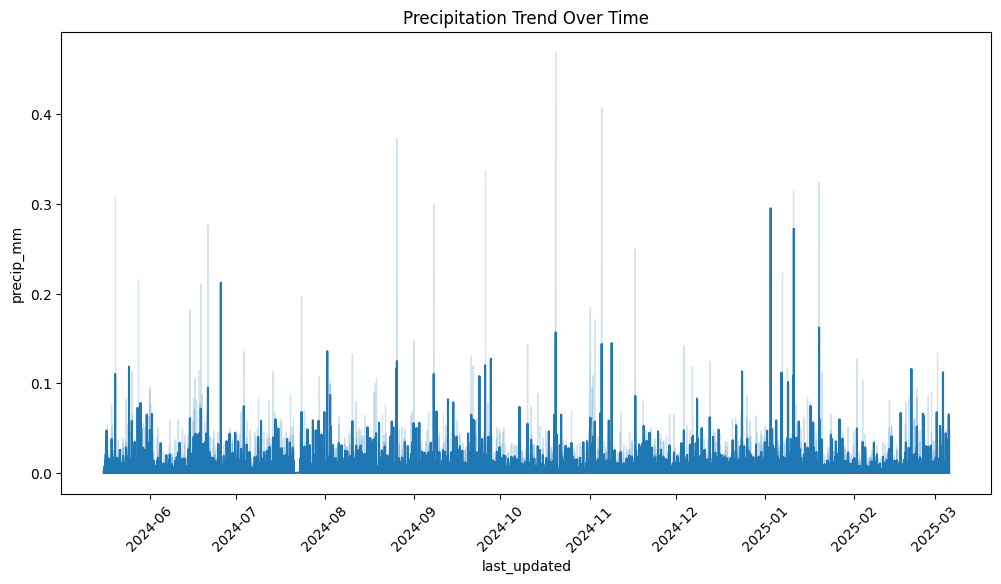

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='last_updated', y='precip_mm', data=weather_data)
plt.title('Precipitation Trend Over Time')
plt.xticks(rotation=45)
plt.show()

# Turning the date into year, month, day, and hour

In [113]:
weather_data['last_updated'] = pd.to_datetime(weather_data['last_updated'])
weather_data['year'] = weather_data['last_updated'].dt.year
weather_data['month'] = weather_data['last_updated'].dt.month
weather_data['day'] = weather_data['last_updated'].dt.day
weather_data['hour'] = weather_data['last_updated'].dt.hour

# Dropping unnecessary columns

In [114]:
weather_data = weather_data.drop(columns=['last_updated', 'location_name', 'country', 'timezone', 'condition_text'])

# One-hot encoding categorical columns and normalizing numerical columns

In [115]:
categorical_columns = ['wind_direction'] 
weather_data_encoded = pd.get_dummies(weather_data, columns=categorical_columns)

print(weather_data_encoded.head())

scaler = StandardScaler()
numerical_columns = weather_data_encoded.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()

weather_data_scaled = weather_data_encoded.copy()
weather_data_scaled[numerical_columns] = scaler.fit_transform(weather_data_encoded[numerical_columns])

print(weather_data_scaled.head())

weather_data[continuous_cols] = scaler.fit_transform(weather_data[continuous_cols])

   latitude  longitude  last_updated_epoch  temperature_celsius  \
0     34.52      69.18          1715849100                 26.6   
1     41.33      19.82          1715849100                 19.0   
2     36.76       3.05          1715849100                 23.0   
3     42.50       1.52          1715849100                  6.3   
4     -8.84      13.23          1715849100                 26.0   

   temperature_fahrenheit  wind_mph  wind_kph  wind_degree  pressure_mb  \
0                    79.8       8.3      13.3          338       1012.0   
1                    66.2       6.9      11.2          320       1012.0   
2                    73.4       9.4      15.1          280       1011.0   
3                    43.3       7.4      11.9          215       1007.0   
4                    78.8       8.1      13.0          150       1011.0   

   pressure_in  ...  wind_direction_NNW  wind_direction_NW  wind_direction_S  \
0        29.89  ...                True              False        

# Features = X; Target variable = y = temperature

In [129]:
cols_to_drop = ['temperature_celsius','temperature_fahrenheit', 'anomaly', 'feels_like_celsius', 'feels_like_fahrenheit', 'temperature_celsius_outlier', 'feels_like_celsius_outlier']
X = weather_data_scaled.drop(columns=cols_to_drop, errors='ignore')  
y = weather_data_scaled['temperature_celsius']

In [130]:
X.columns

Index(['latitude', 'longitude', 'last_updated_epoch', 'wind_mph', 'wind_kph',
       'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in',
       'humidity', 'cloud', 'visibility_km', 'visibility_miles', 'uv_index',
       'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index',
       'wind_mph_outlier', 'pressure_mb_outlier', 'precip_mm_outlier',
       'humidity_outlier', 'cloud_outlier', 'visibility_km_outlier',
       'uv_index_outlier', 'gust_mph_outlier',
       'air_quality_Carbon_Monoxide_outlier', 'air_quality_Ozone_outlier',
       'air_quality_Nitrogen_dioxide_outlier',
       'air_quality_Sulphur_dioxide_outlier', 'air_quality_PM2.5_outlier',
       'air_quality_PM10_outlier', 'year', 'month', 'day', 'hour',
       'wind_direction_E', 'wind_direction_ENE', '

# Splitting into train and test, training te model, calculating evaluation metrics

### Update: MAE = 0.53, MSE, 0.45; R^2 = 0.56!!!

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')


Mean Absolute Error (MAE): 0.5263909279734571
Mean Squared Error (MSE): 0.4513174578380759
R-squared (R2): 0.556533174780706


# Advanced pt1: Anomaly Detection using Isolation Forest

In [120]:
from sklearn.ensemble import IsolationForest

In [132]:
X2 = weather_data_scaled.select_dtypes(include=['float64', 'int64'])

model = IsolationForest(n_estimators=100, contamination=0.05, max_samples='auto', random_state=42)
model.fit(X2)

weather_data_scaled['anomaly'] = model.predict(X2)

weather_data_scaled['anomaly'] = weather_data_scaled['anomaly'].map({1: 0, -1: 1})


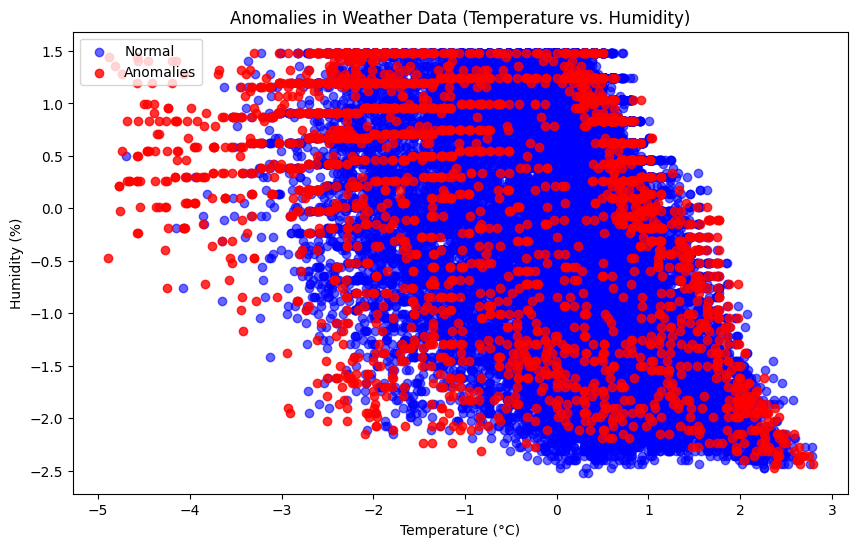

In [134]:
plt.figure(figsize=(10, 6))

normal_data = weather_data_scaled[weather_data_scaled['anomaly'] == 0]
plt.scatter(normal_data['temperature_celsius'], normal_data['humidity'], color='blue', label='Normal', alpha=0.6)

anomalous_data = weather_data_scaled[weather_data_scaled['anomaly'] == 1]
plt.scatter(anomalous_data['temperature_celsius'], anomalous_data['humidity'], color='red', label='Anomalies', alpha=0.8)

plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.legend(loc='upper left')
plt.title('Anomalies in Weather Data (Temperature vs. Humidity)')
plt.show()

In [123]:
anomalies = weather_data_scaled[weather_data_scaled['anomaly'] == 1]
anomalies

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_W,wind_direction_WNW,wind_direction_WSW,anomaly
35,-2.148417,-1.411028,-1.724003,-2.205636,-2.205751,-0.424430,-0.432682,-1.153246,0.349607,0.348478,...,False,False,False,False,False,False,False,False,False,1
36,0.849489,1.431470,-1.724003,0.696735,0.696650,0.118209,0.116121,0.099561,-0.951753,-0.949173,...,False,True,False,False,False,False,False,False,False,1
68,-0.184539,-1.712813,-1.724003,-0.236170,-0.236264,0.565087,0.572356,0.195931,0.349607,0.348478,...,False,True,False,False,False,False,False,False,False,1
78,-1.035539,1.286503,-1.724003,1.007703,1.007622,0.714047,0.711210,-1.056876,-0.517966,-0.508461,...,False,False,False,False,False,False,False,False,False,1
103,-0.652324,1.208246,-1.724003,0.696735,0.696650,-0.147791,-0.141750,-1.442355,-0.445668,-0.435009,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56791,0.580200,0.337442,1.718024,-0.816644,-0.817896,1.043886,1.048426,-0.671397,0.349607,0.372962,...,False,False,False,False,False,False,False,False,False,1
56821,0.011910,-1.843461,1.718024,-1.023956,-1.025211,-0.647869,-0.644269,0.793423,0.783394,0.764706,...,False,False,False,False,False,False,False,False,True,1
56852,0.251244,0.445930,1.718024,0.074798,0.074707,1.405645,1.405479,-0.719582,0.060416,0.054671,...,False,False,False,False,False,False,False,False,False,1
56876,-0.498633,0.876187,1.718146,1.028434,1.030657,0.043729,0.043388,0.793423,-0.373370,-0.410525,...,False,False,False,False,False,False,False,False,True,1


# Trying out different models

In [124]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [125]:
def create_tensorflow_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  ## Final layer has 1 output because this is a regression task (predicting temp)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
X.columns

Index(['latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius',
       'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree',
       'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity',
       'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km',
       'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph',
       'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
       'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
       'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index',
       'air_quality_gb-defra-index'],
      dtype='object')

In [136]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'TensorFlow NN': create_tensorflow_model(X_train.shape[1])
}

/Users/danchizik/Desktop/weather-forcasting/myenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Update:
#### 1. Linear regression: MAE: 0.53, MSE: 0.45, R^2 = 0.56
#### 2. Random Forest: MAE: 0.12, MSE: 0.031, R^2 = 0.9698
#### 3. SVR: MAE: 0.737, MSE: 1.05, R^2 = 0.
#### 4. TensorFlow: MAE: 0.27, MSE: 0.14, R^2 = 0.86

In [137]:
for model_name, model in models.items():
    if model_name == 'TensorFlow NN':
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        y_pred = model.predict(X_test).flatten() 
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} - MAE: {mae}, MSE: {mse}, R²: {r2}")

Linear Regression - MAE: 0.5263909279734571, MSE: 0.4513174578380759, R²: 0.556533174780706
Random Forest - MAE: 0.12304250737207365, MSE: 0.03071311413125074, R²: 0.9698211381371595
SVR - MAE: 0.7372885967833637, MSE: 1.0465556198353059, R²: -0.028350864969837408
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
TensorFlow NN - MAE: 0.2732287032002201, MSE: 0.1410347033027433, R²: 0.861418584561264


# Ensemble model using Voting Regressor

### Update: MAE = 0.41, MSE = 0.29, R^2 = 0.71

In [138]:
from sklearn.ensemble import VotingRegressor

In [139]:
ensemble_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor()),
    ('svr', SVR())
])

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble Model - MAE: {mae_ensemble}, MSE: {mse_ensemble}, R²: {r2_ensemble}")


Ensemble Model - MAE: 0.40880562758194866, MSE: 0.2938194168055434, R²: 0.7112915494501264


# Climate Analysis

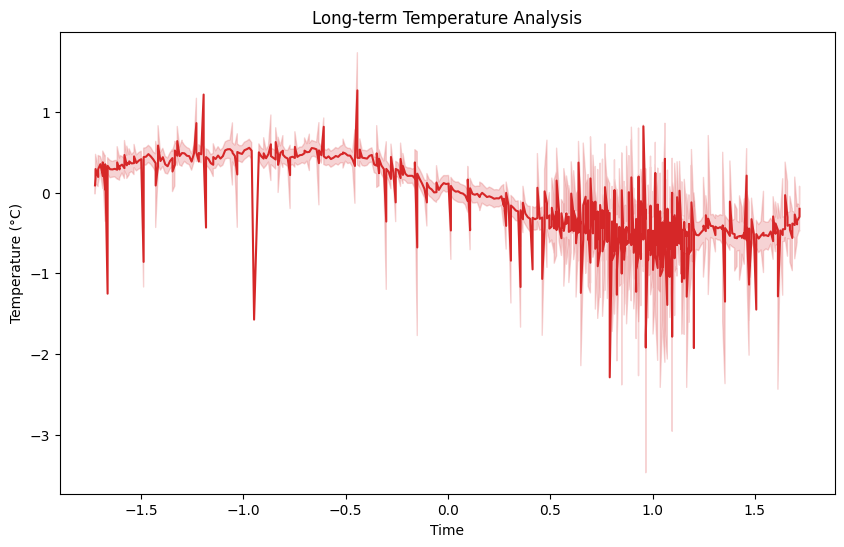

In [141]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=weather_data_scaled['last_updated_epoch'], y=weather_data_scaled['temperature_celsius'], color='tab:red')
plt.title('Long-term Temperature Analysis')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

# Impact on the environment by finding correlation between air quality metrics and temperature

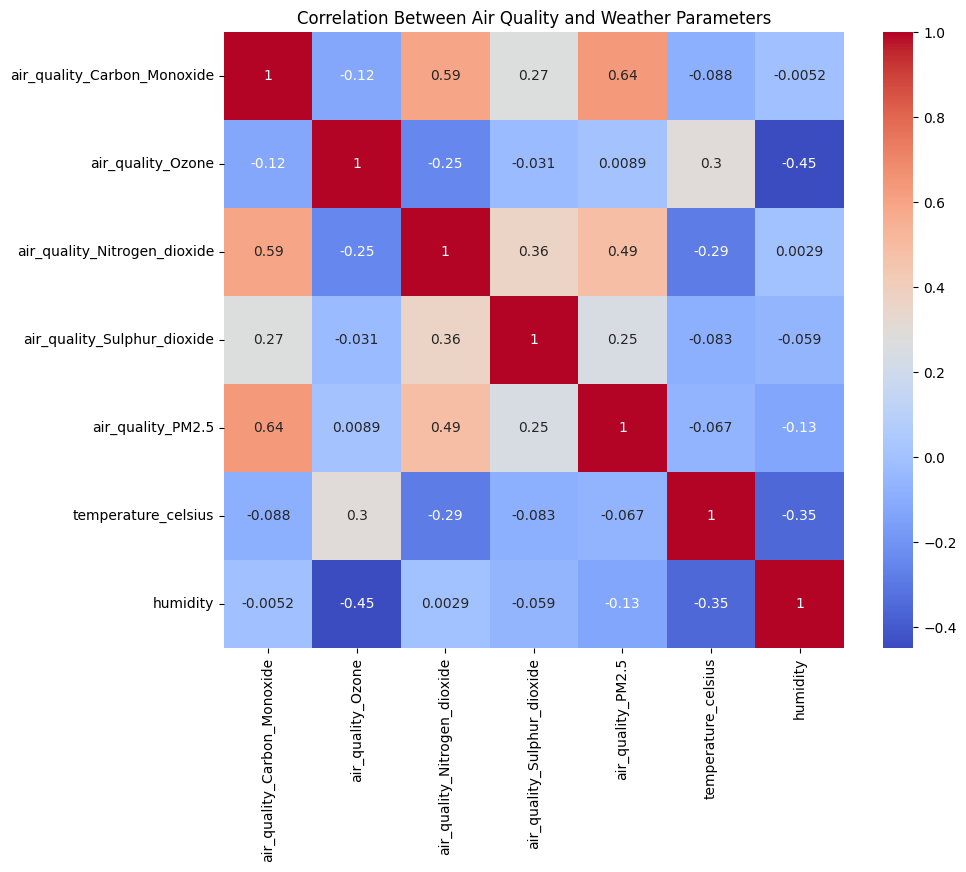

In [142]:
air_quality_cols = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5']
correlation = weather_data_scaled[air_quality_cols + ['temperature_celsius', 'humidity']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Between Air Quality and Weather Parameters')
plt.show()

# Which features are most important in predicting temperature?

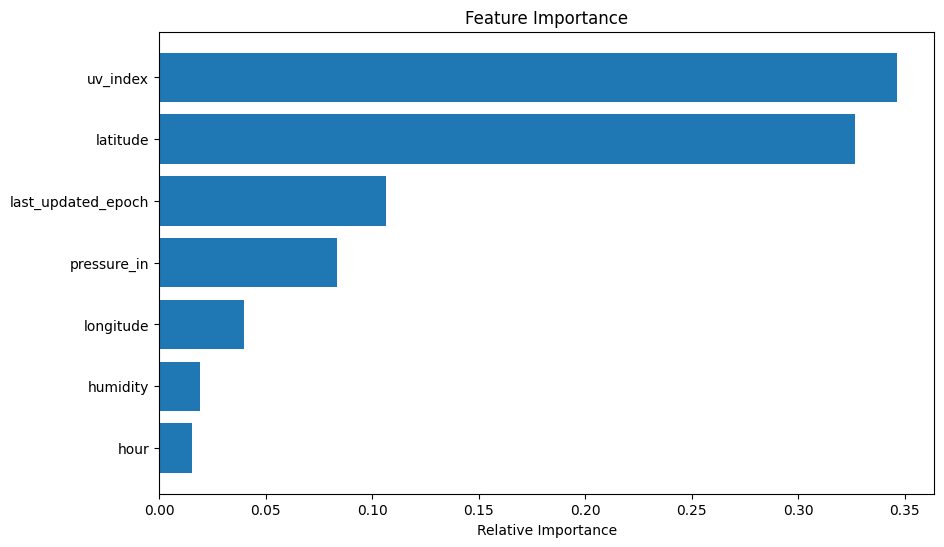

In [145]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Sort feature by importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)

# Filter out features with very low importance (threshold is 0.01 here)
threshold = 0.01
filtered_indices = indices[importances[indices] > threshold]
filtered_importances = importances[filtered_indices]
filtered_features = np.array(X.columns)[filtered_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(filtered_indices)), filtered_importances, align='center')
plt.yticks(range(len(filtered_indices)), filtered_features)
plt.xlabel('Relative Importance')
plt.show()

# Spatial analysis with geopandas

In [146]:
import geopandas as gpd

In [149]:
world = gpd.read_file('../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

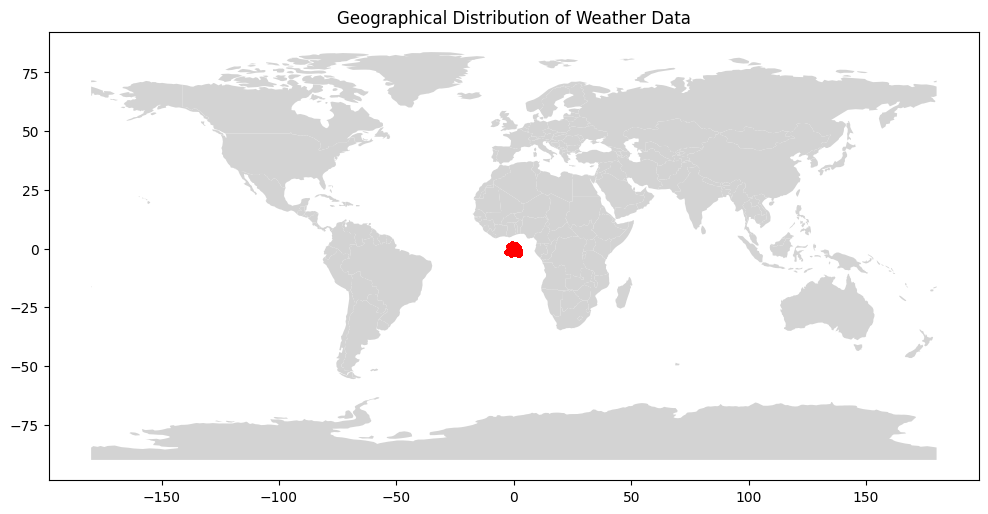

In [150]:
gdf = gpd.GeoDataFrame(weather_data_scaled, geometry=gpd.points_from_xy(weather_data_scaled['longitude'], weather_data_scaled['latitude']))

fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Geographical Distribution of Weather Data')
plt.show()

# Finding geographical patterns with matplotlib

In [154]:
countries = weather_data = pd.read_csv('../data/GlobalWeatherRepository.csv')
countries.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

In [158]:
unique_countries=countries['country'].unique()
print(f'There are {len(unique_countries)} unique values in the country column.')

There are 210 unique values in the country column.


In [159]:
countries.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
